In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

In [2]:
inputFiles = {'spin-1': '../data/2mdm_spin1.pcl',
              'spin-0': '../data/2mdm_spin0.pcl'}

dmData = pd.DataFrame()
for label, f in inputFiles.items():
    df = pd.read_pickle(f)
    df['Mediator'] = label
    dmData = pd.concat((dmData, df))

dmData.sort_values(['Mediator', '$m_{s}$', '$m_{Z^{\prime}}$', '$\sin\\alpha$', '$g_{q}$', '$g_{\chi}$',
                    '$y_{\chi}$', '$m_{\chi}$'], inplace=True, ascending=[False,True,True,True,True,True,True,True])
cmsData = pd.read_pickle('../data/Data_CMS.pcl')
BRdata = pd.read_pickle('../data/BRdata.pcl')

In [3]:
## Filter CMS data

dataFilter = { 
 'Datasetyear': 2017,
 'Region': 'Signal',
 'Fit': 'B-only'}


dfData = cmsData.loc[(cmsData[list(dataFilter)] == pd.Series(dataFilter)).all(axis=1)]

## Filter DM data

filter_spin0 = {
    '$m_{s}$': 400.0,
    '$m_{\chi}$': 65.0,
    '$y_{\chi}$': 1.5,
    '$\sin\\alpha$': 0.25
}
filter_spin1 = {
    '$m_{Z^{\prime}}$': 2000.0,
    '$g_{\chi}$': 1.0,
    '$g_{q}$': 0.25
}

df1, df2 = pd.DataFrame(), pd.DataFrame()
for label in dmData['Mediator']:
    if label == 'spin-0':
        df1 = dmData.loc[(dmData[list(filter_spin0)] == pd.Series(filter_spin0)).all(axis=1)]
    elif label == 'spin-1':
        df2 = dmData.loc[(dmData[list(filter_spin1)] == pd.Series(filter_spin1)).all(axis=1)]
        
dfModel = pd.concat((df1, df2))

In [4]:
## Filter Branching ratio

br_spin0 = {
    'Mediator': 'spin-0',
    '$m_{med}$': 400.0,
    '$y_{\chi}$': 1.5,
    '$\sin\\alpha$': 0.2
}

br_spin1 = {
    'Mediator': 'spin-1',
    '$m_{med}$': 2000.0,
    '$g_{\chi}$': 1.0,
    '$g_{q}$': 0.25
}
br0, br1 = pd.DataFrame(), pd.DataFrame()
for label in BRdata['Mediator']:
    if label == 'spin-0':
        br0 = BRdata.loc[(BRdata[list(br_spin0)] == pd.Series(br_spin0)).all(axis=1)]
    elif label == 'spin-1':
        br1 = BRdata.loc[(BRdata[list(br_spin1)] == pd.Series(br_spin1)).all(axis=1)]
        
br = pd.concat((br0,br1))

In [5]:
# Auxiliar function for plotting
def getBins(dfModel,rightBin = 1400.):
    
    bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c)}    
    binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
    binLeft = [bins[c] for c in bins]+[rightBin] 
    
    return bins,binCenter,binLeft

def getMETbins(dfSingle,bins):

    data = {c : dfSingle[c].iloc[0] for c in bins}

    return data


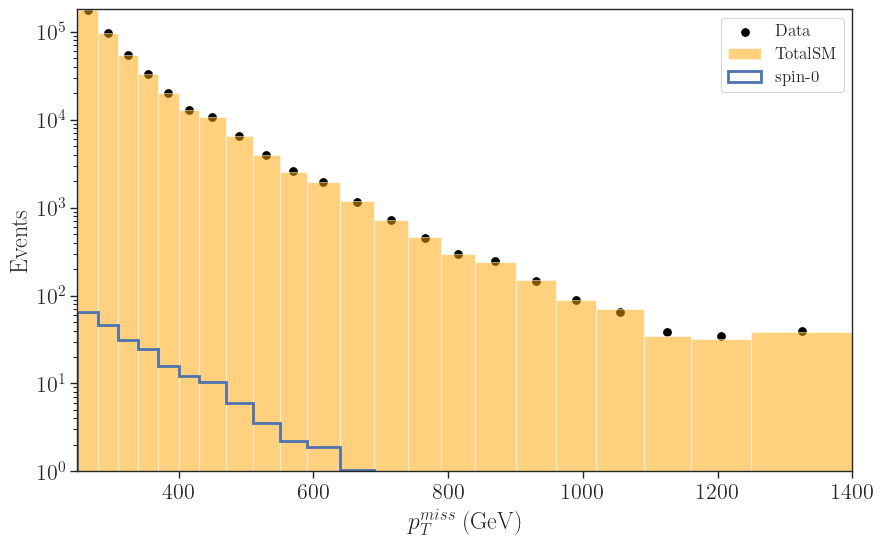

In [6]:
bins, binCenter, binLeft = getBins(dfData)

fig = plt.figure(figsize=(10,6))
for ds in dfData['Datasetyear'].unique():
    dmDS = dfModel[dfModel['Data-takingperiod'] == ds]
    
    weights = {}
    data = {}
    for label in dmDS['Mediator']:
        if label in ['spin-1', 'spin-0']:
            dfSingle = dmDS[dmDS['Mediator'] == label]
            d = getMETbins(dfSingle, bins)
            data[label] = d
            
            weights[label] = np.array([data[label][c] for c in bins])/np.array(br[br['Mediator']==label]['$BR(med>\\chi\\chi)$'])
            
    colors = {label: sns.color_palette('deep')[i] for i, label in enumerate(data.keys())}
    
    dataCMS = {}
    for label in dfData['Process']:
        if label in ['TotalSM', 'Data']:
            dfSingle = dfData[dfData['Process'] == label]
            d = getMETbins(dfSingle, bins)
            dataCMS[label] = d
            
    for label in dataCMS:
        weights[label] = np.array([dataCMS[label][c] for c in bins])
        if label == 'TotalSM':
            plt.hist(binCenter, bins=binLeft, label=label, weights=weights[label], color='orange', alpha=0.5)
        elif label == 'Data':
            plt.scatter(x=binCenter, y=weights[label], s=30, color='black', label=label)
    
    for label in data:
        plt.hist(binCenter, bins=binLeft, label=label, weights=weights[label], histtype='step', linewidth=2.0,
                 color=colors[label])
        
plt.yscale('log')
plt.ylim(1e0,1.8e5)
plt.xlabel(r'$p^{miss}_T$ (GeV)')
plt.ylabel(r'Events')
plt.xlim(250,1400)
plt.legend(loc='upper right', fontsize='x-small')

plt.show()

In [7]:
fig = plt.figure(figsize=(10,6))

plt.hist(binCenter, bins=binLeft, weights=weights['TotalSM']+weights['spin-0']+weights['spin-1'], label='spin-0', stacked=True)
plt.hist(binCenter, bins=binLeft, weights=weights['TotalSM']+weights['spin-1'], label='spin-1', stacked=True)
plt.hist(binCenter, bins=binLeft, weights=weights['TotalSM'], label='SM background', stacked=True)
plt.scatter(x=binCenter, y=weights['Data'], label='Data', color='black')

plt.yscale('log')
# plt.ylim(1e4,1.8e5)
plt.xlabel(r'$p^{miss}_T$ (GeV)')
plt.ylabel(r'Events')
plt.xlim(250,1400)
plt.legend(loc='upper right', fontsize='x-small')

plt.show()

KeyError: 'spin-1'

<Figure size 1000x600 with 0 Axes>

In [23]:
sys.path.append('../../MonoXSMS/CMS-EXO-20-004/statisticalTools/')
from simplifiedLikelihoods import Data,UpperLimitComputer

cmsYieldFile = '../../MonoXSMS/CMS-EXO-20-004/AuxInfo/CMS-EXO-20-004-data/HEPData-ins1894408-v2-csv/Simplifiedlikelihood:Yields(Monojet).csv'
bgYields = np.genfromtxt(cmsYieldFile,delimiter=',',skip_header=5,
                          skip_footer=67,names=True,dtype=None,encoding=None)

dataYields = np.genfromtxt(cmsYieldFile,delimiter=',',skip_header=73,
                           names=True,dtype=None,encoding=None)

covarianceFile = '../../MonoXSMS/CMS-EXO-20-004/AuxInfo/CMS-EXO-20-004-data/HEPData-ins1894408-v2-csv/Simplifiedlikelihood:covariancematrix(Monojet).csv'
cov = np.genfromtxt(covarianceFile,delimiter=',',skip_header=5,
                           names=True,dtype=None,encoding='UTF-8')

In [11]:
weights

{'spin-0': array([6.02798705e+01, 4.27861267e+01, 3.01888242e+01, 2.20014304e+01,
        1.73642546e+01, 1.20454913e+01, 9.30782647e+00, 5.44976441e+00,
        3.63858122e+00, 2.23141187e+00, 1.57932321e+00, 1.05054016e+00,
        4.58618962e-01, 2.84437988e-01, 2.23808063e-01, 1.97118353e-01,
        1.02894793e-01, 7.50167797e-02, 4.20719182e-02, 2.91993925e-02,
        1.55396342e-02, 3.97621718e-02]),
 'spin-1': array([318.47791046, 270.39801947, 222.72906771, 181.63514377,
        151.22564007, 126.15834647, 129.03492114, 110.54265537,
        100.26917439,  73.55812384,  65.75027829,  52.18928339,
         36.16265306,  28.35480751,  27.12198979,  16.43756957,
         20.54696197,  15.20475185,   9.04066326,   6.57502783,
          6.98596707,  10.68442022]),
 'Data': array([1.7617e+05, 9.6067e+04, 5.4789e+04, 3.2767e+04, 2.0209e+04,
        1.2910e+04, 1.0653e+04, 6.4870e+03, 3.9550e+03, 2.5870e+03,
        1.9570e+03, 1.1510e+03, 7.2100e+02, 4.5500e+02, 2.9800e+02,
        